In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import scipy.stats as sps
import seaborn as sns


sns.set(font_scale=1.5)
%matplotlib inline

**Формулировка задачи на простом ”пользовательском” языке:**\
> Мы займемся анализом поездок пользователей в зависимости от типа абономента/подписки. Как используют велопрокат пользователи типа `Member` и `Short-Term Pass Holder`.\

**Формулировка задачи на математическом языке:**\
> Выяснить, как тип пользователя влияет на продолжительность поездки. Узнать, есть ли различие между средним значением продолжительности поездки для подписки типа `Member` и `Short-Term Pass Holder`. 

Загрузим чуть-чуть обработанные данные, где удалены дубликаты первых 50000 поездок в таблице trips.csv.

In [3]:
DATA_DIR = '../data/processed/'

In [4]:
stations_data = pd.read_csv(DATA_DIR+"station.csv")
trips = pd.read_csv(DATA_DIR+"trips.csv", error_bad_lines=False, index_col=0)
weather = pd.read_csv(DATA_DIR+"weather.csv")

In [5]:
trips.head(3)

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
0,431,10/13/2014 10:31,10/13/2014 10:48,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1960.0
1,432,10/13/2014 10:32,10/13/2014 10:48,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1970.0
2,433,10/13/2014 10:33,10/13/2014 10:48,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1988.0


Возможны два типа подписки.

In [6]:
trips.usertype.unique()

array(['Member', 'Short-Term Pass Holder'], dtype=object)

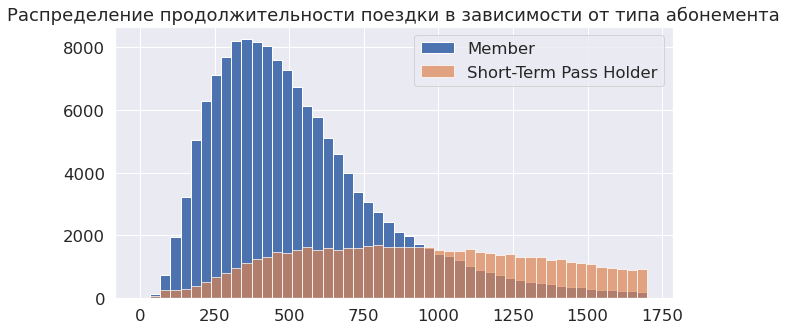

In [7]:
plt.figure(figsize=(10, 5))
plt.title('Распределение продолжительности поездки в зависимости от типа абонемента')
plt.hist(trips[trips['usertype'] == 'Member'].tripduration, 
         bins=50, range=(0, 1700), 
         label='Member')
plt.hist(trips[trips['usertype'] == 'Short-Term Pass Holder'].tripduration, 
         bins=50, range=(0, 1700), 
         label='Short-Term Pass Holder', alpha=0.7)
plt.legend()
plt.show()

Псмотрим на статистики для `tripdaration` для разных типов

In [8]:
trips.drop(['trip_id', 'birthyear'], axis=1).groupby(by=['usertype']).describe()

tripduration                                    \
                              count         mean          std     min   
usertype                                                                
Member                     146171.0   592.977313   731.550556  60.008   
Short-Term Pass Holder      89894.0  2193.901312  2959.113053  60.111   

                                                                    
                             25%        50%         75%        max  
usertype                                                            
Member                  324.2025   479.1490   693.39150  27985.884  
Short-Term Pass Holder  760.0590  1251.4325  2161.54875  28794.398

Можем проверить критерием Уилкоксона-Манна-Уитни гипотезу об однородности.

In [9]:
sps.mannwhitneyu(trips[trips['usertype'] == 'Member'].tripduration, 
                 trips[trips['usertype'] == 'Short-Term Pass Holder'].tripduration)

MannwhitneyuResult(statistic=2077197774.5, pvalue=0.0)

Теперь посмотрим, когда разные типы пользователей пользуются велопрокатом. Построим гистограммы времени начала поездки.

In [11]:
def is_weekend(day):
    return day > 4

In [15]:
trips['starttime'] = pd.to_datetime(trips['starttime'])
trips['stoptime'] = pd.to_datetime(trips['stoptime'])
trips['starttime_of_day_hour'] = [hour for hour in trips['starttime'].dt.hour]
trips['weekend'] = is_weekend(trips.starttime.dt.weekday)

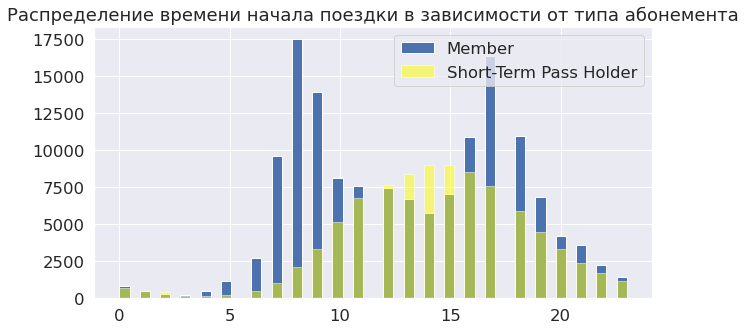

In [13]:
plt.figure(figsize=(10, 5))
plt.title('Распределение времени начала поездки в зависимости от типа абонемента')
plt.hist(trips[trips['usertype'] == 'Member'].starttime_of_day_hour, 
         bins=50, 
         label='Member')
plt.hist(trips[trips['usertype'] == 'Short-Term Pass Holder'].starttime_of_day_hour, 
         bins=50,
         label='Short-Term Pass Holder', alpha=0.5, color='yellow')
plt.legend()
plt.show()

Посмотрим, когда чаще всего катаются `Member`, `Short-Term Pass Holder`.

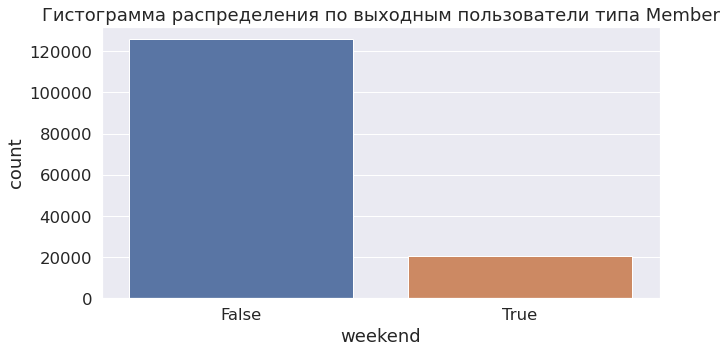

In [18]:
plt.figure(figsize=(10, 5))
plt.title('Гистограмма распределения поездок по выходным пользователи типа Member')
sns.countplot(x='weekend', data=trips[trips['usertype'] == 'Member'])
plt.show()

Как видим, `Member` чаще катаются в будний день.

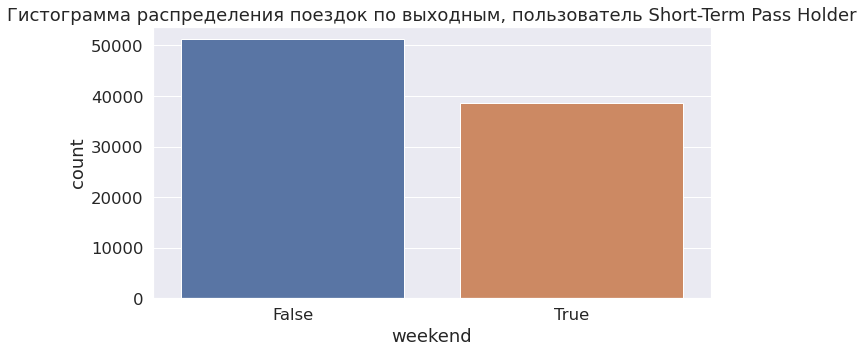

In [20]:
plt.figure(figsize=(10, 5))
plt.title('Гистограмма распределения поездок по выходным, пользователь Short-Term Pass Holder')
sns.countplot(x='weekend', data=trips[trips['usertype'] != 'Member'])
plt.show()

А вот `Short-Term Pass Holder`-пользователи велопрокатата на выходных пользуютя уже чаще.

Посмотрим на распределение пользователей типа `Member` в зависимости от пола.

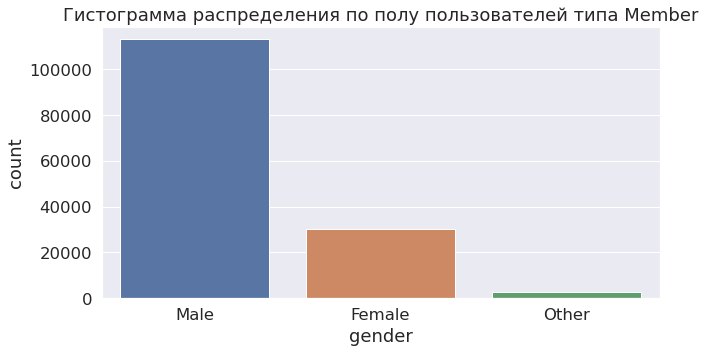

In [46]:
plt.figure(figsize=(10, 5))
plt.title('Гистограмма распределения по полу пользователей типа Member')
sns.countplot(x='gender', data=trips[trips['usertype'] == 'Member'])
plt.show()

При этом важно заметить, что пол пользователя для `Short-Term Pass Holder` подписки не определен, поэтому исследования на эту темы не возможны.

In [14]:
trips[trips.usertype != 'Member'].gender

69        NaN
78        NaN
89        NaN
91        NaN
92        NaN
         ... 
286852    NaN
286853    NaN
286854    NaN
286855    NaN
286856    NaN
Name: gender, Length: 89894, dtype: object

**Выводы:**
* Как видим, разные пользователи по-разному используют велопрокат. Так, пользователи типа `Member` катаются чаще и преимущественно небольшое время, при этом большая часть поездок приходится в начало (8 утра) и коец рабочего дня(17-18 вечера), а вот для `Short-Term Pass Holder` более характерны продолжительные поездки, о чем говорит  и значение средних величин, при чем совершаются они преимущественно днем, в период с 10 до 19 часов. Пользователя типа `Member` также очень редко катаются в выходные, чего нельзя сказать о `Short-Term Pass Holder`.
